In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score
import random

from sklearn.utils import resample

In [2]:
class UNet(nn.Module):
    def __init__(self, embedding_size=64):
        super(UNet, self).__init__()

        # Define the encoder part
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Define the bottleneck part
        self.bottleneck_conv = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7*7*64, embedding_size)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_conv1(x))
        x = self.pool(x)
        x = F.relu(self.enc_conv2(x))
        x = self.pool(x)

        # Bottleneck
        x = F.relu(self.bottleneck_conv(x))
        x = self.flatten(x)
        x = self.fc(x)

        return x

model = UNet()

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
def split_data(train_dataset):
    data = {}
    for x in range(10):
        data[x] = [data for data in train_dataset if data[1] == x]
        random.shuffle(data[x])
    return data

In [6]:
def create_biased_dataset(data, probs):
    '''
    probs: [p_0, p_1, ..., p_9]
    returns a biased dataset according to probs
    '''
    max_p = max(probs)
    max_x = np.argmax(probs)
    max_n = 0.9 * len(data[max_x])
    res = []
    for x, lis in data.items():
        n = int(max_n * probs[x] / max_p)
        res += data[x][:n]
    random.shuffle(res)
    return res

In [7]:
def encode_data(dataset):
  model.eval() # UNet
  return [(model(image.unsqueeze(0)), label) for image, label in dataset]

In [8]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cpu	CPU


In [47]:
class BiasedRandomForestClassifier(RandomForestClassifier):
    def __init__(self,
                 n_estimators=100,
                 criterion='gini',
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.0,
                 max_features='sqrt',
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.0,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 random_state=None,
                 verbose=0,
                 warm_start=False,
                 class_weight=None,
                 ccp_alpha=0.0,
                 max_samples=None,
                n_classes = 10):

        super(BiasedRandomForestClassifier, self).__init__(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            max_samples=max_samples)
        
        self.n_classes = n_classes
        self.thresholds = [1/self.n_classes for _ in range(self.n_classes)]

    def fit(self, X, y, sample_weight=None):
        return super(BiasedRandomForestClassifier, self).fit(X, y, sample_weight)

    def fit_thresholds(self, X, y, alpha = 0.01, batches = 50, sample_weight = None):
        X_batches = np.array_split(X, batches)
        y_batches = np.array_split(y, batches)
        cnt = 0
        for X_batch, y_batch in zip(X_batches, y_batches):
            cnt += 1
            y_pred = self.predict(X_batch)
            for y_p, y in zip(y_pred, y_batch):
                if y_p != y:
                    diff = alpha * self.thresholds[y]
                    self.thresholds[y_p] += diff
                    self.thresholds[y] -= diff
#             print('Batch No: ', cnt, '\nThresholds: ', self.thresholds)
        return self.thresholds

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba - self.thresholds, axis = 1)
    
    def predict_biased(self, X, train_ratios, test_ratios):
        proba = self.predict_proba(X)
        for i in range(10):
            proba[:, i] *= test_ratios[i] / train_ratios[i]
        proba /= proba.sum(axis = 1, keepdims = True)
        return np.argmax(proba - self.thresholds, axis = 1)

In [10]:
model.eval()  # Set the model to evaluation mode

# Get one batch of images from the train loader
images, labels = next(iter(train_loader))

# Select the first image from this batch
# The shape of 'image' will be [1, 1, 28, 28], which is what the model expects
image = images[0].unsqueeze(0)

# Forward pass to get the embedding
embedding = model(image)

embedding.shape

torch.Size([1, 64])

In [20]:
encoded_train = encode_data([data for data in train_dataset])

In [30]:
def make_biased_dataset(balanced_data, ratios):
    biased_datasets = {}
    encoded_biased_datasets = {}
    data = split_data(balanced_data)
    n = 10
    for ratio in ratios:
        probs = [ratio] + [(1 - ratio)/(n - 1)] * (n -1)
        biased_datasets[ratio] = create_biased_dataset(data, probs)
        encoded_biased_datasets[ratio] = encode_data(biased_datasets[ratio])
        
    return encoded_biased_datasets

ratios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
encoded_test = make_biased_dataset(test_dataset, ratios)

In [22]:
def upsampling(X, y):
    labels = np.unique(y)
    data = {}
    max_length = 0
    res = X
    for i, y0 in enumerate(labels):
        data[y0] = [X[i] for i in range(len(X)) if y[i] == y0]
        max_length = max(len(data[y0]), max_length)
    for y0 in data:
        l = len(data[y0])
        X_new = random.choices(data[y0], k = max_length - l, random_state = 0)
        if len(X_new) < 1:
            continue
        y_new = [y0] * len(X_new)
        X = np.vstack((X, X_new))
        y = np.vstack((y, y_new))
    return X, y

In [24]:
def evaluate_models_many_train(training_datasets, test_dataset):
    # Prepare the test data
    X_test, y_test = zip(*[(x.detach().numpy().flatten(), y) for x, y in test_dataset])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    accuracies = []
    precisions = []
    recalls = []
    ratios = []
    og_accuracies = []
    og_precisions = []
    og_recalls = []

    for ratio, dataset in training_datasets.items():
        # Prepare the training data
        X_train, y_train = zip(*[(x.detach().numpy().flatten(), y) for x, y in dataset])
        X, y = X_train, y_train
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        n_estimators = 100
        max_depth = 5

        model = BiasedRandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
        X_resampled, y_resampled = upsampling(X_train, y_train)
        model.fit(X_resampled, y_resampled)
        thresholds = model.fit_thresholds(X_resampled, y_resampled)
        og = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)
        og.fit(X_resampled, y_resampled)
        
        print('Sample Bias Ratio: ', ratio)
        print('Fitted thresholds: ', thresholds)

        predictions = model.predict_biased(X_test)
        accuracies.append(accuracy_score(y_test, predictions))
        og_accuracies.append(accuracy_score(y_test, og.predict(X_test)))
        og_precisions.append(precision_score(y_test, og.predict(X_test), average='macro'))
        og_recalls.append(recall_score(y_test, og.predict(X_test), average='macro'))
        precisions.append(precision_score(y_test, predictions, average='macro'))
        recalls.append(recall_score(y_test, predictions, average='macro'))
        ratios.append(ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_accuracies, label='RF Accuracy', color='blue')
    plt.plot(ratios, accuracies, label='DeBOT Accuracy', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_precisions, label='RF Precision', color='blue')
    plt.plot(ratios, precisions, label='DeBOT Precision', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_recalls, label='RF Recall', color='blue')
    plt.plot(ratios, recalls, label='DeBOT Recall', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()

In [48]:
def evaluate_models(training_dataset, test_datasets):
    # Prepare the test data
    
    accuracies = []
    precisions = []
    recalls = []
    ratios = []
    og_accuracies = []
    og_precisions = []
    og_recalls = []
    
    X_train, y_train = zip(*[(x.detach().numpy().flatten(), y) for x, y in training_dataset])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_estimators = 100
    max_depth = 5

    model = BiasedRandomForestClassifier()
    model.fit(X_train, y_train)
    og = RandomForestClassifier()
    og.fit(X_train, y_train)

    for ratio, test_dataset in test_datasets.items():
        print('Test Bias Ratio: ', ratio)
        #print('Fitted thresholds: ', thresholds)
        
        X_test, y_test = zip(*[(x.detach().numpy().flatten(), y) for x, y in test_dataset])
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        predictions = model.predict_biased(X_test, [0.1] * 10, [ratio] + [(1-ratio)/9]*9)
        accuracies.append(accuracy_score(y_test, predictions))
        og_accuracies.append(accuracy_score(y_test, og.predict(X_test)))
        og_precisions.append(precision_score(y_test, og.predict(X_test), average='macro'))
        og_recalls.append(recall_score(y_test, og.predict(X_test), average='macro'))
        precisions.append(precision_score(y_test, predictions, average='macro'))
        recalls.append(recall_score(y_test, predictions, average='macro'))
        ratios.append(ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_accuracies, label='RF Accuracy', color='blue')
    plt.plot(ratios, accuracies, label='DeBOT Accuracy', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_precisions, label='RF Precision', color='blue')
    plt.plot(ratios, precisions, label='DeBOT Precision', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(ratios, og_recalls, label='RF Recall', color='blue')
    plt.plot(ratios, recalls, label='DeBOT Recall', color='red')

    plt.xlabel('Fraction of 0')
    plt.ylabel('Performance Metrics')
    plt.title('Performance Metrics for Different Sample Ratios')
    plt.legend()
    plt.grid(True)
    plt.show()

Test Bias Ratio:  0.2
Test Bias Ratio:  0.3
Test Bias Ratio:  0.4
Test Bias Ratio:  0.5
Test Bias Ratio:  0.6
Test Bias Ratio:  0.7
Test Bias Ratio:  0.8
Test Bias Ratio:  0.9


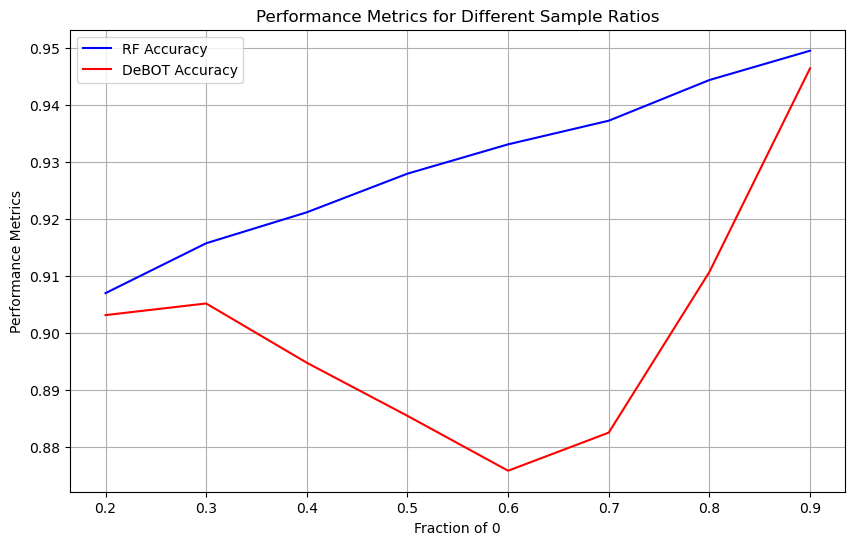

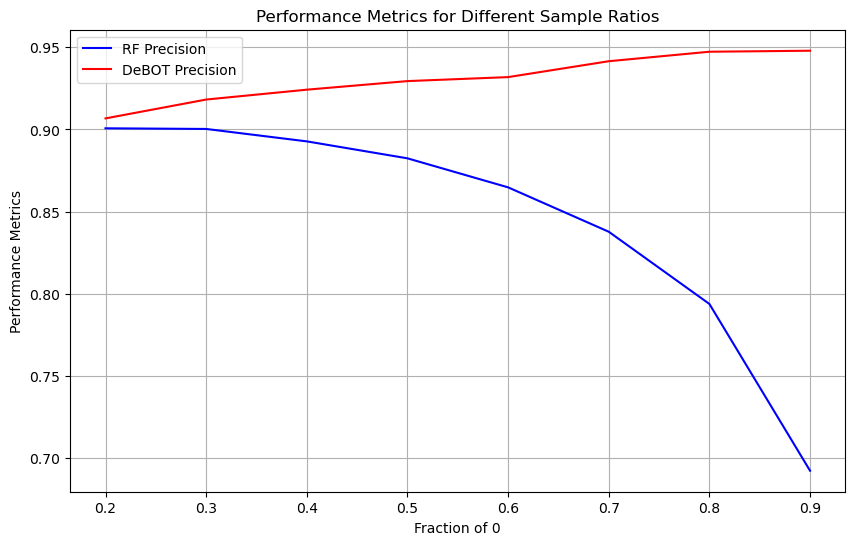

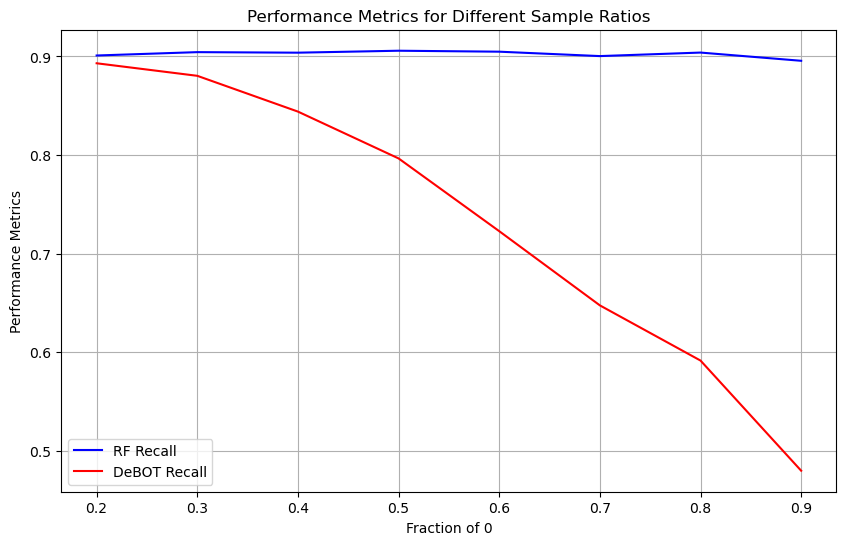

In [49]:
evaluate_models(encoded_train, encoded_test)